In [1]:
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrix, dmatrices

In [2]:
TREAT_STATES_YEARS = {"AZ": 2006, "CA": 2002, "CO": 2004, "CT": 1998, "DE": 2005, "HI": 2001, "IL": 2007, "IN": 2011, "IA": 1983, "KS": 2009, "ME": 1999, "MD": 2004, "MA": 1997, "MI": 2008, "MN": 2007, "MO": 2007, "MT": 2005, "NV": 1997, "NH": 2007, "NJ": 1991, "NM": 2002, "NY": 2004, "NC": 2007, "ND": 2007, "OH": 2008, "OK": 2010, "OR": 2007, "PA": 2004, "RI": 2004, "SC": 2014, "SD": 2008, "TX": 1999, "UT": 2008, "VT": 2005, "VA": 2007, "WA": 2006, "WV": 2009, "WI": 1998, "DC": 2005}
TREAT_STATES = set(TREAT_STATES_YEARS.keys())
CTRL_STATES = {"GA", "KY", "ID", "AL", "MS", "FL", "LA", "WY", "TN", "NE", "AK", "AR"}
ALL_STATES = TREAT_STATES | CTRL_STATES

In [3]:
full_df = pd.read_csv("Datasets/seds.csv")
orig_num_rows = full_df.shape[0]
full_df.dropna(inplace=True)

print("Dropped {} rows".format(orig_num_rows - full_df.shape[0]))
print(full_df.shape)
display.display(full_df.describe())
display.display(full_df.head(10))

Dropped 28158 rows
(1683578, 8)


,year,value
count,1.683578e+06,1.683578e+06
mean,1.990484e+03,1.077022e+05
std,1.567905e+01,1.383675e+06
min,1.960000e+03,-7.090800e+05
25%,1.977000e+03,1.033000e+00
50%,1.991000e+03,8.400000e+01
75%,2.004000e+03,6.942000e+03
max,2.017000e+03,1.009913e+08


,year,msn,state_name,state_code,description,energy_bin,value,unit
0,1960,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
1,1961,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
2,1962,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
3,1963,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
4,1964,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
5,1965,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
6,1966,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
7,1967,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
8,1968,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
9,1969,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu


In [4]:
# asphalt_output = full_df.loc[full_df["msn"] == "ESTCB"]
# display.display(asphalt_output.groupby("state_code")["value"].mean())

In [5]:
full_df["year_categ"] = full_df["year"].astype("category")

# time-fixed effects
year_df = pd.DataFrame()
year_df["year_categ"] = full_df["year_categ"].unique()
year_df["year_categ"] = year_df["year_categ"].astype("category")
year_df["key"] = 0

# unit-fixed effects
state_df = pd.DataFrame()
state_df["state_code"] = list(ALL_STATES)
state_df["state_code"] = state_df["state_code"].astype("category")
state_df["key"] = 0

# treatment indicator
regressors_df = pd.merge(year_df, state_df, on="key")
regressors_df.drop("key", axis=1, inplace=True)
regressors_df["treated"] = regressors_df.apply(
        lambda r: r["state_code"] in TREAT_STATES and r["year_categ"] > TREAT_STATES_YEARS[r["state_code"]],
        axis=1)
regressors_df.sort_values(["state_code", "year_categ"], inplace=True)
regressors_df.reset_index(drop=True, inplace=True)

In [6]:
def preprocess(target_msn):
    target_df = full_df[full_df["msn"] == target_msn][["state_code", "year_categ", "value"]]
    target_df.sort_values(["state_code", "year_categ"], inplace=True)
    target_df.reset_index(drop=True, inplace=True)

    prepped_df = pd.merge(regressors_df, target_df, on=["state_code", "year_categ"], sort=True)
    display.display(prepped_df.head(10))
    
    return prepped_df, target_df

In [7]:
def fit_model(df):
    y, X = dmatrices("value ~ year_categ + state_code + treated", data=prepped_df, return_type="dataframe")
    model = sm.RLM(y, X)
    res = model.fit()
    return res

In [8]:
def visualize(results, target_df, state_code, start_year):
    df_policy = regressors_df[(regressors_df["year_categ"].astype("int") >= start_year) & (regressors_df["state_code"] == state_code)]
    df_nopolicy = df_policy.copy()
    df_nopolicy["treated"] = False
    target_df = target_df[(target_df["year_categ"].astype("int") >= start_year) & (target_df["state_code"] == state_code)]
    
    policy_predictions = results.predict(dmatrix("year_categ + state_code + treated", data=df_policy, return_type="dataframe"))
    nopolicy_predictions = results.predict(dmatrix("year_categ + state_code + treated", data=df_nopolicy, return_type="dataframe"))
    plt.plot(list(df_policy["year_categ"]), list(policy_predictions), label="Predictions with policy")
    plt.plot(list(df_nopolicy["year_categ"]), list(nopolicy_predictions), label="Predictions without policy")
    plt.plot(list(target_df["year_categ"]), list(target_df["value"]), label="Actual")
    plt.legend()
    plt.title("Results for {}".format(state_code))
    plt.show()

,year_categ,state_code,treated,value
0,1960,AK,False,1011.0
1,1961,AK,False,1175.0
2,1962,AK,False,1359.0
3,1963,AK,False,1649.0
4,1964,AK,False,1824.0
5,1965,AK,False,2107.0
6,1966,AK,False,2365.0
7,1967,AK,False,2533.0
8,1968,AK,False,2863.0
9,1969,AK,False,3201.0


                    Robust linear Model Regression Results                    
Dep. Variable:                  value   No. Observations:                 2958
Model:                            RLM   Df Residuals:                     2849
Method:                          IRLS   Df Model:                          108
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 23 Feb 2019                                         
Time:                        13:16:06                                         
No. Iterations:                     5                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -8.89e+04   7749

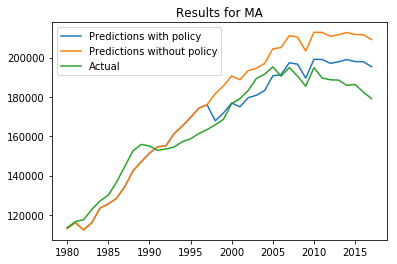

In [9]:
prepped_df, target_df = preprocess("ESTCB")
res = fit_model(prepped_df)
print(res.summary())
visualize(res, target_df, "MA", 1980)